In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D,
    BatchNormalization, ReLU,
    GlobalAveragePooling2D, Dense, Add
)
from tensorflow.keras import Model
import matplotlib.pyplot as plt

Load Dataset

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    r'C:\Data Sets\Plant classification\train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True,
    seed=42
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    r'C:\Data Sets\Plant classification\val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=False,
    seed=42
)

Found 21000 files belonging to 30 classes.
Found 3000 files belonging to 30 classes.


In [4]:
for images, labels in train_ds.take(1):
    image = images[1]
    print(image.numpy())


[[[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 ...

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]]


In [5]:
# Normalization
normalization = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(
    lambda x, y: (normalization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

validation_ds = validation_ds.map(
    lambda x, y: (normalization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [6]:
for images, labels in train_ds.take(1):
    image = images[1]
    print(image.numpy())


[[[0.9843138  0.97647065 0.98823535]
  [0.98095244 0.9731093  0.99271715]
  [0.9725491  0.9686275  0.9921569 ]
  ...
  [0.8027762  0.81061935 0.8576782 ]
  [0.7756613  0.7835044  0.83056325]
  [0.7543854  0.76222855 0.80928737]]

 [[0.98640585 0.9785627  0.9903274 ]
  [0.98095244 0.9731093  0.99271715]
  [0.97165245 0.9677309  0.9912603 ]
  ...
  [0.801382   0.80922514 0.85628396]
  [0.7864814  0.7943245  0.84138334]
  [0.7623161  0.77015924 0.81721807]]

 [[0.98823535 0.9803922  0.9921569 ]
  [0.9846251  0.97678196 0.9963898 ]
  [0.9686275  0.96470594 0.98823535]
  ...
  [0.80460703 0.8124502  0.859509  ]
  [0.7896677  0.79751086 0.84456974]
  [0.75648755 0.7643307  0.8113895 ]]

 ...

 [[0.2202896  0.19937728 0.16333659]
  [0.18205887 0.16463059 0.13456252]
  [0.14862713 0.13175675 0.11675572]
  ...
  [0.627451   0.6122023  0.5864933 ]
  [0.62502265 0.60977393 0.57970583]
  [0.6158715  0.6006228  0.5705547 ]]

 [[0.22013058 0.18707736 0.15290368]
  [0.23730876 0.21770091 0.1941715 ]


In [7]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [8]:
# Performance optimization
train_ds = (
    train_ds
    .cache()
    .shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)

validation_ds = (
    validation_ds
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
# Sanity check
for images, labels in train_ds.take(1):
    print("Images:", images.shape)
    print("Labels:", labels.shape)


Images: (32, 224, 224, 3)
Labels: (32,)


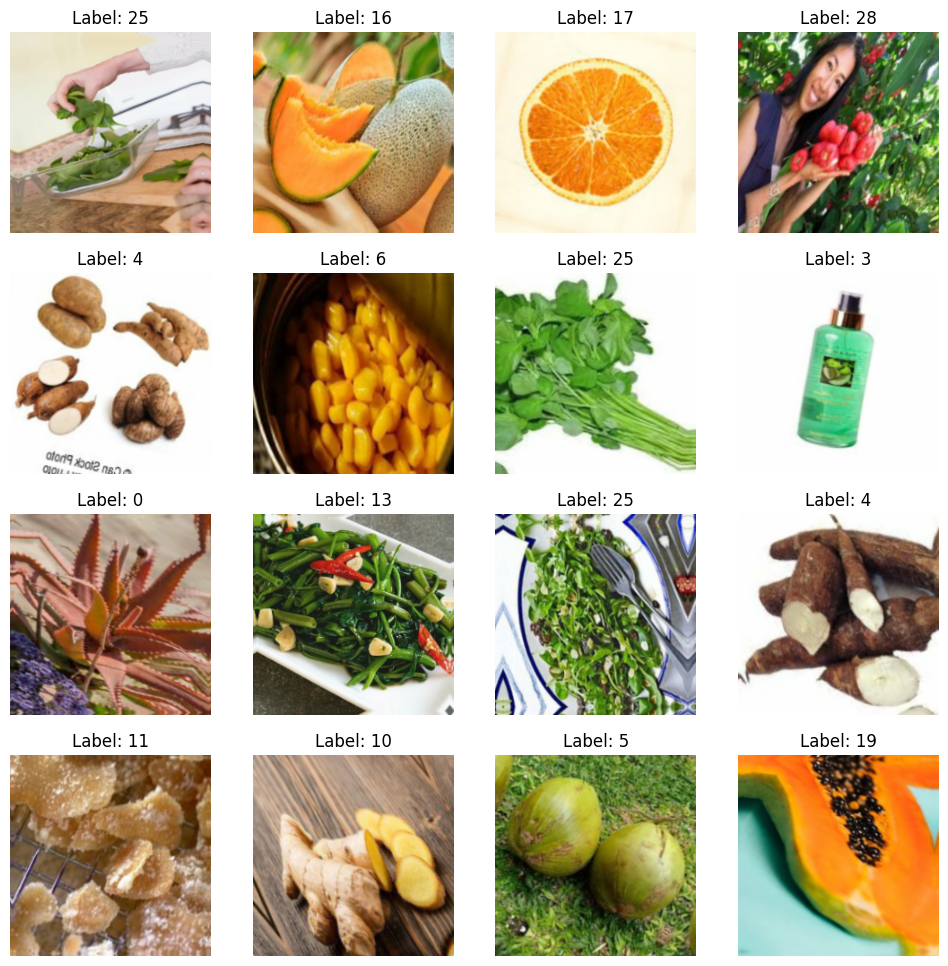

In [10]:
# Get one batch from training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))

    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    
    plt.show()

In [11]:
def inverted_residual_block(x, out_channels, stride, expansion):
    residual = x
    in_channels = x.shape[-1]

    # Expantion phase (1 x 1)
    if expansion != 1:
        x = Conv2D(
            filters=in_channels * expansion,
            kernel_size=1,
            padding='same',
            use_bias=False
        )(x)
        x = BatchNormalization()(x)
        x = ReLU(6.)(x)
        
    # Depthwise convolution (3 x 3)
    x = DepthwiseConv2D(
        kernel_size = 3,
        strides = stride,
        padding = 'same',
        use_bias = False
    )(x)

    x = BatchNormalization()(x)

    x = ReLU(6.)(x)
    
    # Projection phase (1 x 1)
    x = Conv2D(
        filters = out_channels,
        kernel_size = 1,
        padding = 'same',
        use_bias = False
    )(x)

    x = BatchNormalization()(x)

    if stride == 1 and in_channels == out_channels:
        x = Add()([residual, x])

    return x

In [12]:
def MobileNet(input_shape=(224, 224, 3), num_classes=30):
    inputs = Input(shape=input_shape)

    # Initial convolution (stem)
    x = Conv2D(
        filters = 32,
        kernel_size = 3,
        strides = 2,
        padding = 'same',
        use_bias = False
    )(inputs)

    x = BatchNormalization()(x)

    x = ReLU(6.)(x)


    # Block configuration
    config = [
        (1,  16, 1, 1),            # (expansion, output_channels, repeats, stride)
        (6,  24, 2, 2),
        (6,  32, 3, 2),
        (6,  64, 4, 2),
        (6,  96, 3, 1),
        (6, 160, 3, 2),
        (6, 320, 1, 1),
    ]

    # Build inverted residual blocks
    for expansion, channels, repeats, stride in config:
        for i in range(repeats):
            s = stride if i == 0 else 1
            x = inverted_residual_block(x, channels, s, expansion)

    # Final convolution
    x = Conv2D(
        filters = 1280,
        kernel_size = 1,
        padding = 'same',
        use_bias = False
    )(x)

    x = BatchNormalization()(x)

    x = ReLU(6.)(x)


    # Classification head
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

In [13]:
model = MobileNet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 112, 112, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 112, 112, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 112, 112, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ depthwise_conv2d              │ (None, 112, 112, 32)      │             288 │ re_lu[0][0]                │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 112, 112, 32)      │             128 │ depthwise_conv2d[0][0]     │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 112, 112, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 112, 112, 16)      │             512 │ re_lu_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 112, 112, 16)      │              64 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 112, 112, 96)      │           1,536 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 112, 112, 96)      │             384 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_2 (ReLU)                │ (None, 112, 112, 96)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ depthwise_conv2d_1            │ (None, 56, 56, 96)        │             864 │ re_lu_2[0][0]              │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 56, 56, 96)        │             384 │ depthwise_conv2d_1[0][0]   │
│ (BatchNormalization)          │                           │               

 Total params: 2,296,414 (8.76 MB)

 Trainable params: 2,262,302 (8.63 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [14]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']

)

In [17]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=8
)

Epoch 1/8
657/657 ━━━━━━━━━━━━━━━━━━━━ 3798s 6s/step - accuracy: 0.4684 - loss: 1.7486 - val_accuracy: 0.4217 - val_loss: 2.2998
Epoch 2/8
657/657 ━━━━━━━━━━━━━━━━━━━━ 3634s 6s/step - accuracy: 0.5151 - loss: 1.5807 - val_accuracy: 0.4713 - val_loss: 1.9217
Epoch 3/8
657/657 ━━━━━━━━━━━━━━━━━━━━ 3842s 6s/step - accuracy: 0.5593 - loss: 1.4600 - val_accuracy: 0.3910 - val_loss: 2.6047
Epoch 4/8
657/657 ━━━━━━━━━━━━━━━━━━━━ 2672s 4s/step - accuracy: 0.5857 - loss: 1.3484 - val_accuracy: 0.5227 - val_loss: 1.9733
Epoch 5/8
657/657 ━━━━━━━━━━━━━━━━━━━━ 2206s 3s/step - accuracy: 0.6192 - loss: 1.2198 - val_accuracy: 0.5457 - val_loss: 1.6922
Epoch 6/8
657/657 ━━━━━━━━━━━━━━━━━━━━ 2202s 3s/step - accuracy: 0.6481 - loss: 1.1111 - val_accuracy: 0.5480 - val_loss: 1.7261
Epoch 7/8
657/657 ━━━━━━━━━━━━━━━━━━━━ 2207s 3s/step - accuracy: 0.6822 - loss: 1.0038 - val_accuracy: 0.5340 - val_loss: 2.0391
Epoch 8/8
657/657 ━━━━━━━━━━━━━━━━━━━━ 2172s 3s/step - accuracy: 0.7046 - loss: 0.8997 - val_accu

In [19]:
y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

cm = tf.math.confusion_matrix(
    y_true,
    y_pred,
    num_classes=30
)

print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━

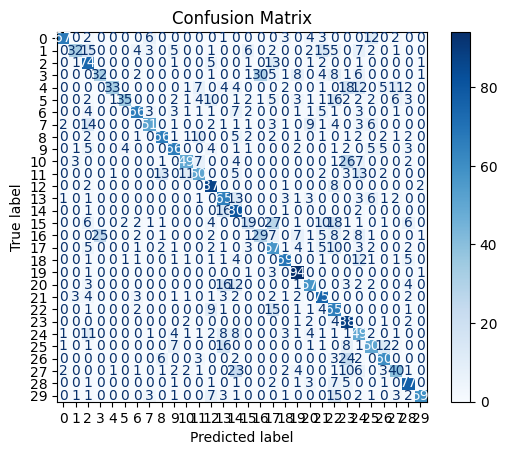

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.67      0.77       100
           1       0.78      0.32      0.45       100
           2       0.47      0.74      0.58       100
           3       0.56      0.32      0.41       100
           4       0.92      0.33      0.49       100
           5       0.83      0.35      0.49       100
           6       0.78      0.66      0.71       100
           7       0.75      0.51      0.61       100
           8       0.73      0.66      0.69       100
           9       0.68      0.66      0.67       100
          10       0.69      0.49      0.57       100
          11       0.59      0.50      0.54       100
          12       0.62      0.87      0.72       100
          13       0.48      0.65      0.55       100
          14       0.46      0.80      0.58       100
          15       0.47      0.19      0.27       100
          16       0.48      0.29      0.36       100
          17       0.40    

In [24]:
# Save the model
model.save("model_plant_classification.keras")